In [ ]:
!pip install numpy pandas matplotlib seaborn scipy statsmodels gmaps geemap

In [ ]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import normaltest
from statsmodels.graphics.gofplots import qqplot

In [3]:
df = pd.read_csv('drive/My Drive/mta_1706.csv', error_bad_lines=False, low_memory=False, warn_bad_lines=False)

In [4]:
df.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime
0,2017-06-01 00:03:34,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_430,40.635170,-73.960803,FOSTER AV/E 18 ST,approaching,76.0,2017-06-01 00:03:59,24:06:14
1,2017-06-01 00:03:43,1,S61,ST GEORGE FERRY/S61 & S91,40.643169,-74.073494,S I MALL YUKON AV,40.575935,-74.167686,NYCT_8263,40.590802,-74.158340,MERRYMOUNT ST/TRAVIS AV,approaching,62.0,2017-06-01 00:03:56,23:58:02
2,2017-06-01 00:03:49,0,Bx10,E 206 ST/BAINBRIDGE AV,40.875008,-73.880142,RIVERDALE 263 ST,40.912376,-73.902534,NYCT_4223,40.886010,-73.912647,HENRY HUDSON PKY E/W 235 ST,at stop,5.0,2017-06-01 00:03:56,24:00:53
3,2017-06-01 00:03:31,0,Q5,TEARDROP/LAYOVER,40.701748,-73.802399,ROSEDALE LIRR STA via MERRICK,40.666012,-73.735939,NYCT_8422,40.668002,-73.729348,HOOK CREEK BL/SUNRISE HY,< 1 stop away,267.0,2017-06-01 00:04:03,24:03:00
4,2017-06-01 00:03:22,1,Bx1,RIVERDALE AV/W 231 ST,40.881187,-73.909340,MOTT HAVEN 136 ST via CONCOURSE,40.809654,-73.928360,NYCT_4710,40.868134,-73.893032,GRAND CONCOURSE/E 196 ST,at stop,11.0,2017-06-01 00:03:56,23:59:38


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6730436 entries, 0 to 6730435
Data columns (total 17 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   RecordedAtTime             object 
 1   DirectionRef               int64  
 2   PublishedLineName          object 
 3   OriginName                 object 
 4   OriginLat                  float64
 5   OriginLong                 float64
 6   DestinationName            object 
 7   DestinationLat             float64
 8   DestinationLong            float64
 9   VehicleRef                 object 
 10  VehicleLocation.Latitude   float64
 11  VehicleLocation.Longitude  float64
 12  NextStopPointName          object 
 13  ArrivalProximityText       object 
 14  DistanceFromStop           float64
 15  ExpectedArrivalTime        object 
 16  ScheduledArrivalTime       object 
dtypes: float64(7), int64(1), object(9)
memory usage: 872.9+ MB




---



**Nominal or Categorical Datatype Example**

In [6]:
df.DirectionRef.unique()

array([0, 1])

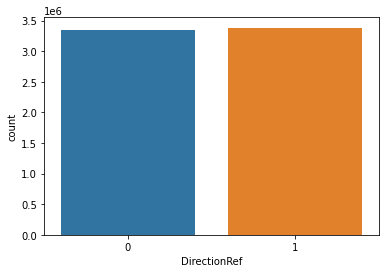

In [7]:
sns.countplot(x='DirectionRef', data=df)
plt.show()



---



**Measures of Central Tendency**

**Mean** of every numeric column(interval and ratio type data) present in the dataset

In [8]:
colMeans = df.drop('DirectionRef', axis=1).mean(axis=0, numeric_only=True)
print(colMeans)

OriginLat                     40.729610
OriginLong                   -73.931110
DestinationLat                40.728634
DestinationLong              -73.931565
VehicleLocation.Latitude      40.728485
VehicleLocation.Longitude    -73.930712
DistanceFromStop             225.881287
dtype: float64




---



**Median** of every numeric column(interval and ratio type data) present in the dataset

In [47]:
colMedians = df.drop('DirectionRef', axis=1).median(axis=0, numeric_only=True)
print(colMedians)

OriginLat                    40.715233
OriginLong                  -73.932449
DestinationLat               40.713356
DestinationLong             -73.932266
VehicleLocation.Latitude     40.723225
VehicleLocation.Longitude   -73.936528
DistanceFromStop             89.000000
dtype: float64




---



**Using Mean and Median**

To find the location which is equidistant from all the bus stops

In [45]:
from math import cos, sin, radians, atan2, sqrt, degrees, pi

pos = pd.DataFrame()

pos["Lat"] = np.hstack((df.OriginLat.dropna(), df.DestinationLat.dropna()))
pos["Lat"] = pos.Lat.apply(radians)

pos["Lon"] = np.hstack((df.OriginLong.dropna(), df.DestinationLong.dropna()))
pos["Lon"] = pos.Lon.apply(radians)

pos = pos.drop_duplicates()

pos["X"] = np.vectorize(lambda lat, lon: cos(lat)*cos(lon))(pos["Lat"], pos["Lon"])
pos["Y"] = np.vectorize(lambda lat, lon: cos(lat)*sin(lon))(pos["Lat"], pos["Lon"])
pos["Z"] = np.vectorize(sin)(pos["Lat"])

x = pos.X.mean() # pos.X.median()
y = pos.Y.mean() # pos.Y.median()
z = pos.Z.mean() # pos.Z.median()

Center_Lon = atan2(y, x)
Hyp = sqrt(x*x + y*y)
Center_Lat = atan2(z, Hyp)

print(f"Location Equidistant from all bus stops: {degrees(Center_Lat)} N, {-1*degrees(Center_Lon)} W")

Location Equidistant from all bus stops: 40.717734964493395 N, 73.93840305614441 W


The above location remains the same for both **mean** and **median** values



---



To locate the above found location on the map

In [52]:
center = (degrees(Center_Lat),degrees(Center_Lon))

from ipyleaflet import Map, Marker, MarkerCluster
m = Map(center=center, zoom=10)

markers=list()
markers = ( Marker(location=(degrees(i[0]), degrees(i[1]))) for i in np.array(pos) )

marker = Marker(location=center, draggable=False)
marker_cluster = MarkerCluster( markers=tuple(markers) )

m.add_layer(marker)
m.add_layer(marker_cluster)
display(m)

Map(center=[40.72110900074779, -73.94301950727649], controls=(ZoomControl(options=['position', 'zoom_in_text',…



---



**Mode** of every column present in the dataset(Nominal, interval and ratio type data)

In [ ]:
colModes = df.mode(axis=0)
colModes.head()



---



**Using Mode**

To find Common Initial(origin) and Final(destination) Stops with respect to directionRef(0 or 1).

In [12]:
origins = [
    df[df.DirectionRef==i]['OriginName'].value_counts().idxmax() 
    for i in df.DirectionRef.unique()
]
print(f"Common Origins:\n\tDir-0: {origins[0]}\n\tDir-1: {origins[1]}\n")

destinations = [
    df[df.DirectionRef==i]['DestinationName'].value_counts().idxmax() 
    for i in df.DirectionRef.unique()
]
print(f"Common Destinations:\n\tDir-0: {destinations[0]}\n\tDir-1: {destinations[1]}\n")

Common Origins:
	Dir-0: MERRICK BL/ARCHER AV
	Dir-1: E 126 ST/2 AV

Common Destinations:
	Dir-0: ST GEORGE FERRY
	Dir-1: WASHINGTON HTS GW BRIDGE





---



To find the most frequent paths from those Initial Stops(origins)

In [13]:
paths_from_origins = list( map( lambda x : 
                               [ 
                                   x,
                                   df[ df.OriginName == x ][ "DestinationName" ].value_counts().idxmax(),
                                   df[ df.OriginName == x ][ "DestinationName" ].value_counts()[0]
                               ],
                               origins
                              )
                         )
print("Most Common Paths from Common Origins:\n")
k=0
for i in paths_from_origins:
    print("\tDirection Reference:", k)
    k+=1
    print("\tFrom:", i[0])
    print("\tTo:", i[1])
    print("\tNo of Trips:", i[2],"\n")

Most Common Paths from Common Origins:

	Direction Reference: 0
	From: MERRICK BL/ARCHER AV
	To: SELECT BUS BRONX ZOO via MAIN ST
	No of Trips: 40732 

	Direction Reference: 1
	From: E 126 ST/2 AV
	To: SELECT BUS SERVICE SOUTH FERRY via 2 AV
	No of Trips: 51015 





---



To find the most frequent paths to those Final Stops(destinations)

In [14]:
paths_to_destinations = list( map( lambda x : 
                               [ 
                                   x,
                                   df[ df.DestinationName == x ][ "OriginName" ].value_counts().idxmax(),
                                   df[ df.DestinationName == x ][ "OriginName" ].value_counts()[0]
                               ],
                               destinations
                              )
                         )

print("\nMost Common Paths to Common Destination:\n")
k=0
for i in paths_to_destinations:
    print("\tDirection Reference:", k)
    k+=1
    print("\tFrom:", i[0])
    print("\tTo:", i[1])
    print("\tNo of Trips:", i[2],"\n")


Most Common Paths to Common Destination:

	Direction Reference: 0
	From: ST GEORGE FERRY
	To: YUKON AV/KMART DWY
	No of Trips: 21421 

	Direction Reference: 1
	From: WASHINGTON HTS GW BRIDGE
	To: RANDALL AV/OLMSTEAD AV
	No of Trips: 30743 





---



To find the number of buses from the above initial stops to the final stops

In [15]:
ini_stop_0 = df[df["DirectionRef"]==0]['OriginName'].mode().get(0)
ini_stop_1 = df[df["DirectionRef"]==1]['OriginName'].mode().get(0)
fin_stop_1 = df[df["DirectionRef"]==1]['DestinationName'].mode().get(0)
fin_stop_0 = df[df["DirectionRef"]==0]['DestinationName'].mode().get(0)

The most frequent path with DirectionRef = 0

In [16]:
(df[df["DirectionRef"]==0][df['OriginName']==ini_stop_0].mode())[["OriginName", "DestinationName"]]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,OriginName,DestinationName
0,MERRICK BL/ARCHER AV,SELECT BUS BRONX ZOO via MAIN ST


The most frequent path with DirectionRef = 1

In [17]:
(df[df["DirectionRef"]==1][df['OriginName']==ini_stop_1].mode())[["OriginName", "DestinationName"]]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,OriginName,DestinationName
0,E 126 ST/2 AV,SELECT BUS SERVICE SOUTH FERRY via 2 AV


To find the number of buses for the above paths

In [18]:
print(df[df["DirectionRef"]==0][df['OriginName']==ini_stop_0][["OriginName", "DestinationName"]][df.DestinationName==fin_stop_0].count(),"\n")
print(df[df["DirectionRef"]==0][df['OriginName']==ini_stop_0][["OriginName", "DestinationName"]][df.DestinationName==fin_stop_1].count())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


OriginName         0
DestinationName    0
dtype: int64 



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


OriginName         0
DestinationName    0
dtype: int64


We find that there are no buses directly from those most frequent initial to final stops



---



From the above results, we also find that the central tendency measures(mean, median and mode) are the same for all the numeric columns(interval type data) except for the DistanceFromStop column(ratio type data)



---



**Distribution Type**

To identify the distribution type of data using visualizations like histograms, box-plot, kernel density estimation(kdeplot) and Quantile-Quantile(qqplot).



*   Origin Latitude column


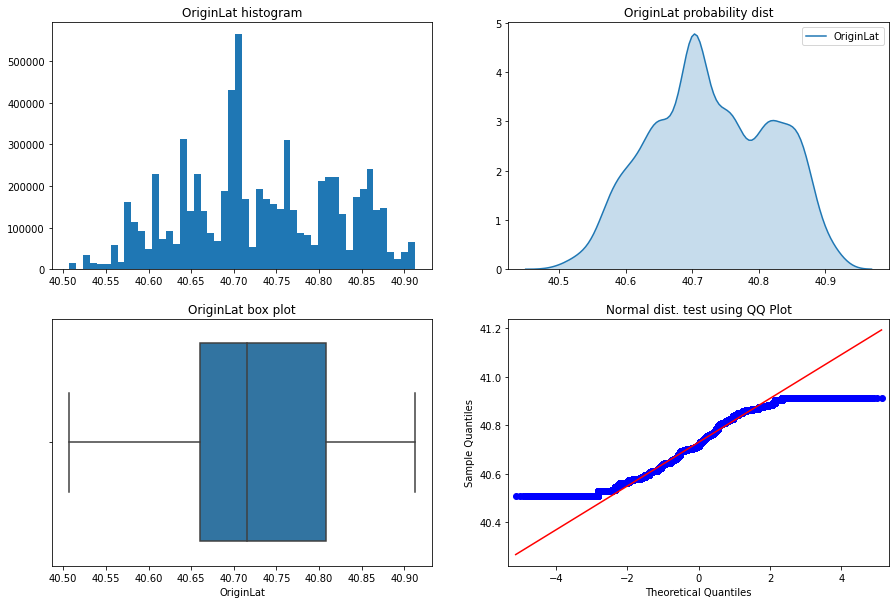

In [20]:
fig, a = plt.subplots(2, 2, figsize = (15, 10))

a[0][0].hist(df['OriginLat'].dropna(), bins=50)
a[0][0].set_title('OriginLat histogram')

sns.kdeplot(df['OriginLat'].dropna(), bw=0.019, shade='blue', ax=a[0][1])
a[0][1].set_title('OriginLat probability dist')

sns.boxplot(x=df['OriginLat'].dropna(), ax=a[1][0])
a[1][0].set_title('OriginLat box plot')

qqplot(df['OriginLat'].dropna(), line='s', ax=a[1][1])
a[1][1].set_title('Normal dist. test using QQ Plot')

plt.show()



*   Origin Longitude column



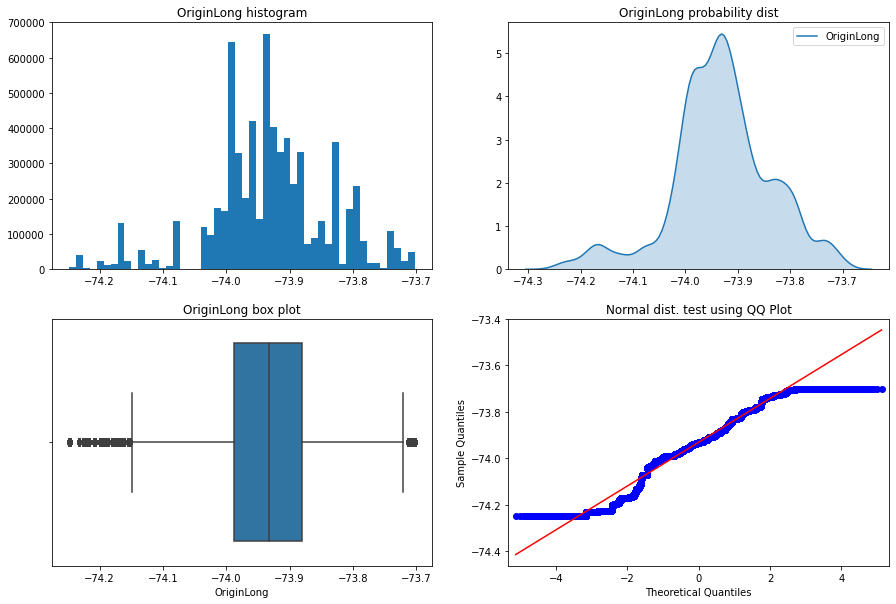

In [21]:
fig, a = plt.subplots(2, 2, figsize = (15, 10))

a[0][0].hist(df['OriginLong'].dropna(), bins=50)
a[0][0].set_title('OriginLong histogram')

sns.kdeplot(df['OriginLong'].dropna(), bw=0.019, shade='blue', ax=a[0][1])
a[0][1].set_title('OriginLong probability dist')

sns.boxplot(x=df['OriginLong'].dropna(), ax=a[1][0])
a[1][0].set_title('OriginLong box plot')

qqplot(df['OriginLong'].dropna(), line='s', ax=a[1][1])
a[1][1].set_title('Normal dist. test using QQ Plot')

plt.show()



*   Destination Latitude column



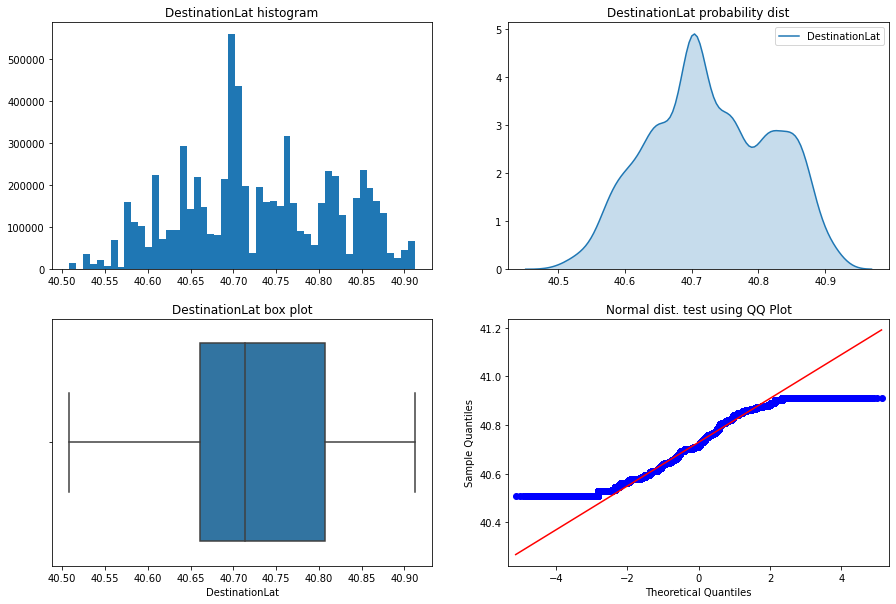

In [48]:
fig, a = plt.subplots(2, 2, figsize = (15, 10))

a[0][0].hist(df['DestinationLat'].dropna(), bins=50)
a[0][0].set_title('DestinationLat histogram')

sns.kdeplot(df['DestinationLat'].dropna(), bw=0.019, shade='blue', ax=a[0][1])
a[0][1].set_title('DestinationLat probability dist')

sns.boxplot(x=df['DestinationLat'].dropna(), ax=a[1][0])
a[1][0].set_title('DestinationLat box plot')

qqplot(df['DestinationLat'].dropna(), line='s', ax=a[1][1])
a[1][1].set_title('Normal dist. test using QQ Plot')

plt.show()

*   Destination Longitude column data



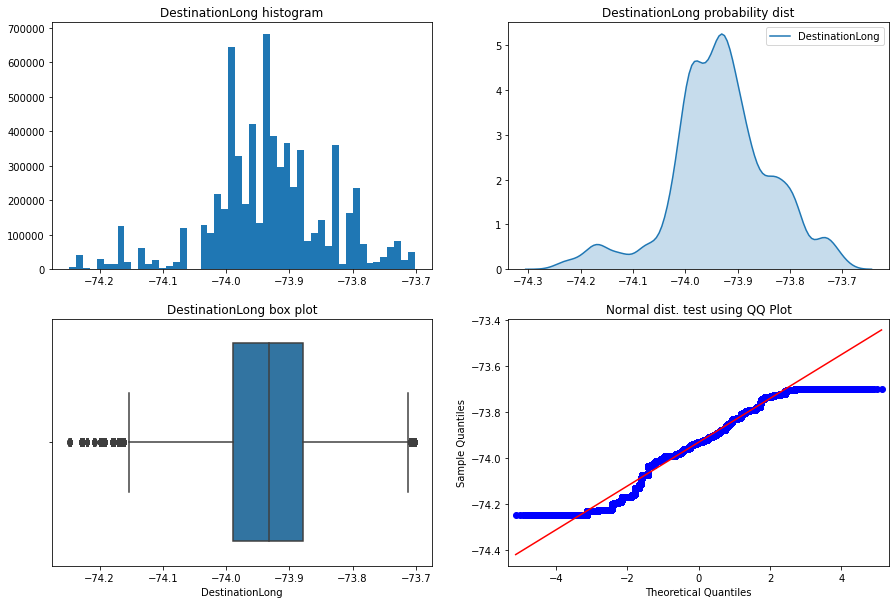

In [49]:
fig, a = plt.subplots(2, 2, figsize = (15, 10))

a[0][0].hist(df['DestinationLong'].dropna(), bins=50)
a[0][0].set_title('DestinationLong histogram')

sns.kdeplot(df['DestinationLong'].dropna(), bw=0.019, shade='blue', ax=a[0][1])
a[0][1].set_title('DestinationLong probability dist')

sns.boxplot(x=df['DestinationLong'].dropna(), ax=a[1][0])
a[1][0].set_title('DestinationLong box plot')

qqplot(df['DestinationLong'].dropna(), line='s', ax=a[1][1])
a[1][1].set_title('Normal dist. test using QQ Plot')

plt.show()



*   Vehicle Location Latitude column





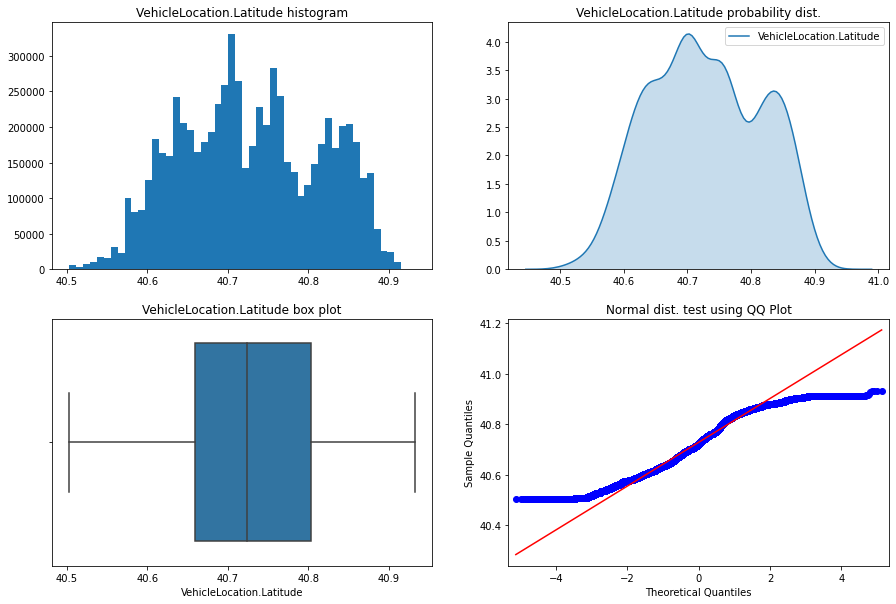

In [22]:
fig, a = plt.subplots(2, 2, figsize = (15, 10))

a[0][0].hist(df['VehicleLocation.Latitude'].dropna(), bins=50)
a[0][0].set_title('VehicleLocation.Latitude histogram')

sns.kdeplot(df['VehicleLocation.Latitude'].dropna(), bw=0.019, shade='blue', ax=a[0][1])
a[0][1].set_title('VehicleLocation.Latitude probability dist.')

sns.boxplot(x=df['VehicleLocation.Latitude'].dropna(), ax=a[1][0])
a[1][0].set_title('VehicleLocation.Latitude box plot')

qqplot(df['VehicleLocation.Latitude'].dropna(), line='s', ax=a[1][1])
a[1][1].set_title('Normal dist. test using QQ Plot')

plt.show()



*   Vehicle Location Longitude column



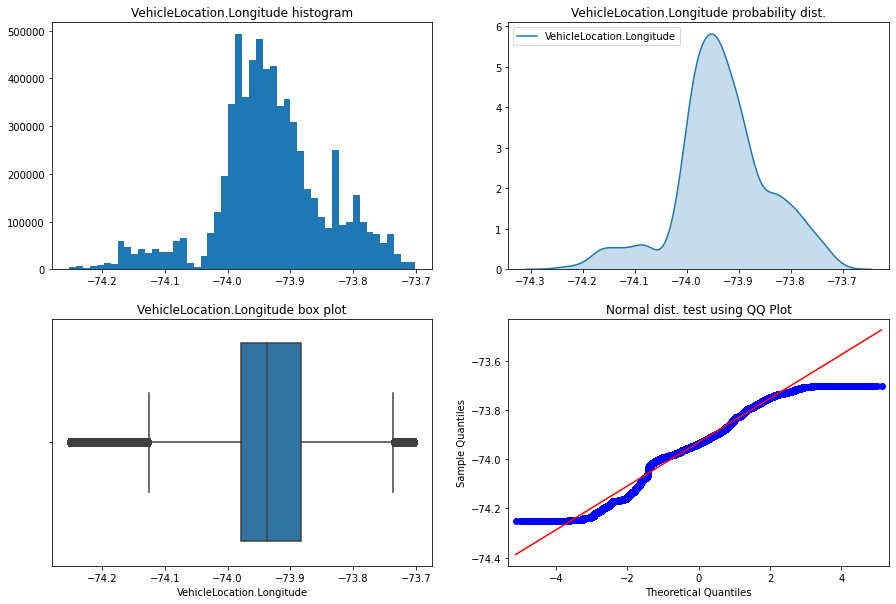

In [23]:
fig, a = plt.subplots(2, 2, figsize = (15, 10))

a[0][0].hist(df['VehicleLocation.Longitude'].dropna(), bins=50)
a[0][0].set_title('VehicleLocation.Longitude histogram')

sns.kdeplot(df['VehicleLocation.Longitude'].dropna(), bw=0.019, shade='blue', ax=a[0][1])
a[0][1].set_title('VehicleLocation.Longitude probability dist.')

sns.boxplot(x=df['VehicleLocation.Longitude'].dropna(), ax=a[1][0])
a[1][0].set_title('VehicleLocation.Longitude box plot')

qqplot(df['VehicleLocation.Longitude'].dropna(), line='s', ax=a[1][1])
a[1][1].set_title('Normal dist. test using QQ Plot')

plt.show()

The above plots show that, the data follows normal distribution although there is a slight deviation from the actual distribution owing to the presence of certain outliers and the fact that no real time data can be perfect. Adding to the above observations we've also pointed that the central tendency measures are all equal which is usually the case when the data follows a normal distribution.



---





*   Distance From Stop column



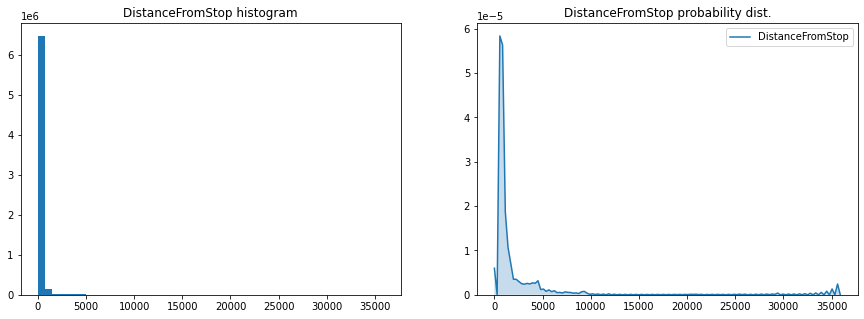

In [51]:
fig, a = plt.subplots(1, 2, figsize = (15, 5))

a[0].hist(df['DistanceFromStop'].dropna(), bins=50)
a[0].set_title('DistanceFromStop histogram')

sns.kdeplot(df['DistanceFromStop'].dropna(), bw=0.019, shade='blue', ax=a[1])
a[1].set_title('DistanceFromStop probability dist.')

plt.show()

The above plots show that DistanceFromStop follows an exponential distribution because the number of buses reaching the intended stop grows exponentially.



---

